# Anàlisi de correlació entre trànsit aeri i qualitat de l'aire

Aquest notebook constitueix el nucli analític quantitatiu del treball. Un cop netejades les dades i visualitzada la seva distribució espacial, l'objectiu és determinar si existeix una relació estadística significativa entre la densitat de trànsit aeri i els nivells de contaminació mesurats per l'índex ICA.

**Objectiu**

L'objectiu principal és respondre a la pregunta de recerca: Influeix el volum de trànsit aeri immediat en la qualitat de l'aire local a nivell de superfície?

Per fer-ho, es realitzen els passos següents:

- Integració Espai-Temporal: Unificar els conjunts de dades (ADS-B i ICA) en una mateixa malla espaial i resolució temporal.

- Anàlisi de Correlació: Calcular coeficients estadístics (Pearson i Spearman) per quantificar la relació lineal o monòtona.

- Modelització Lineal: Ajustar un model de regressió simple per avaluar la capacitat predictiva del trànsit sobre l'ICA.

- Avaluació de Residus: Analitzar els errors del model per validar la seva fiabilitat.

In [1]:
# Importar les biblioteques necessàries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, shapiro
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_55/3582284136.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Configuració visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Carregar dades preprocessades

In [3]:
# Carregar dades
adsb_path = Path("../data/processed/adsb/adsb_clean.csv")
df_adsb = pd.read_csv(adsb_path)

ica_path = Path("../data/processed/ica/ica_clean.csv")
df_ica = pd.read_csv(ica_path)

# Convertir timestamps
df_adsb['hora'] = pd.to_datetime(df_adsb['hora'])
df_ica['hora'] = pd.to_datetime(df_ica['hora'])

# Resum bàsic
print(f"\nVolum de dades:")
print(f"- ADS-B: {len(df_adsb):,} registres")
print(f"- ICA: {len(df_ica):,} registres")

print(f"\nPeríode temporal:")
print(f"- ADS-B: {df_adsb['hora'].min()} fins {df_adsb['hora'].max()}")
print(f"- ICA: {df_ica['hora'].min()} fins {df_ica['hora'].max()}")

print(f"\nCobertura geogràfica:")
print(f"- Grid cells amb trànsit: {df_adsb['cell_id'].nunique()}")
print(f"- Estacions ICA: {df_ica['cod_estacion'].nunique()}")
print(f"- Avions únics detectats: {df_adsb['hex'].nunique()}")


Volum de dades:
- ADS-B: 75,989 registres
- ICA: 12,625 registres

Període temporal:
- ADS-B: 2025-10-11 06:00:00 fins 2025-10-12 06:00:00
- ICA: 2025-10-11 04:00:00 fins 2025-10-12 06:00:00

Cobertura geogràfica:
- Grid cells amb trànsit: 563
- Estacions ICA: 505
- Avions únics detectats: 2943


## 2. Preparació per l'anàlisi

Per poder comparar dos fenòmens dispars (vols en moviment i estacions estàtiques), és necessari crear un marc comú. S'utilitza l'estratègia de **Grid Espacial** definida prèviament:

- **Agregació Espacial:** S'assigna cada vol i cada estació ICA a una cel·la de $0.5^\circ \times 0.5^\circ$ (cell_id).
- **Agregació Temporal:** S'agrupen les dades per hores (hora).
- **Fusió (Merge):** Es crea un únic dataset on cada fila representa una cel·la i una hora concreta, contenint el nombre de vols detectats i la mitjana de l'ICA.

**Nota:** Només es conserven els registres on hi ha coincidència espai-temporal (inner join), assegurant que comparem vols i contaminació en el mateix lloc i moment.

### 2.1 Agregació per zona i hora

In [4]:
# Densitat d'avions per grid cell i hora
# IMPORTANT: UUtilitzem 'nunique' per comptar avions ÚNICS, no deteccions
densitat_avions = df_adsb.groupby(['cell_id', 'lat_centre', 'lon_centre', 'hora']).agg({
    'hex': 'nunique',  # Avions ÚNICS (no deteccions)
    'alt_baro': 'mean',  # Altitud mitjana
    'gs': 'mean'  # Velocitat mitjana
}).reset_index()

densitat_avions.columns = ['cell_id', 'lat_centre', 'lon_centre', 'hora', 
                            'num_avions', 'alt_mitjana', 'velocitat_mitjana']

print(f"\nAgregació de trànsit aeri:")
print(f"- Observacions (cell + hora): {len(densitat_avions):,}")
print(f"- Rang d'avions per observació: {densitat_avions['num_avions'].min():.0f} - {densitat_avions['num_avions'].max():.0f}")
print(f"- Mitjana d'avions per observació: {densitat_avions['num_avions'].mean():.1f}")


Agregació de trànsit aeri:
- Observacions (cell + hora): 10,769
- Rang d'avions per observació: 1 - 44
- Mitjana d'avions per observació: 7.0


In [5]:
# ICA per estació i hora
ica_aggregat = df_ica.groupby(['cod_estacion', 'nombre', 'lat', 'lon', 'hora', 'tipo']).agg({
    'indice': 'mean',
    'debido_a': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
}).reset_index()

ica_aggregat.columns = ['cod_estacion', 'nombre', 'lat', 'lon', 'hora', 
                        'tipo', 'ica_mitjà', 'contaminant_principal']

print(f"\nAgregació de qualitat de l'aire:")
print(f"- Observacions (estació + hora): {len(ica_aggregat):,}")
print(f"- Rang d'ICA: {ica_aggregat['ica_mitjà'].min():.1f} - {ica_aggregat['ica_mitjà'].max():.1f}")
print(f"- ICA mitjà global: {ica_aggregat['ica_mitjà'].mean():.2f}")


Agregació de qualitat de l'aire:
- Observacions (estació + hora): 12,625
- Rang d'ICA: 0.0 - 30.0
- ICA mitjà global: 5.60


In [6]:
# Assignar cada estació ICA a la seva grid cell més propera
def assignar_cell(lat, lon, grid_size=0.5):
    """Assigna coordenades a una grid cell de 0.5° x 0.5°"""
    lat_cell = int((lat - 35.0) / grid_size)
    lon_cell = int((lon - (-10.0)) / grid_size)
    cell_id = f"{lat_cell}_{lon_cell}"
    lat_centre = 35.0 + lat_cell * grid_size + grid_size/2
    lon_centre = -10.0 + lon_cell * grid_size + grid_size/2
    return cell_id, lat_centre, lon_centre

ica_aggregat[['cell_id', 'lat_cell_centre', 'lon_cell_centre']] = ica_aggregat.apply(
    lambda row: assignar_cell(row['lat'], row['lon']), 
    axis=1, 
    result_type='expand'
)

print(f"\nAssignació espacial:")
print(f"- Estacions assignades a {ica_aggregat['cell_id'].nunique()} grid cells")


Assignació espacial:
- Estacions assignades a 143 grid cells


In [7]:
# Combinar dades: unir densitat d'avions amb ICA per cell_id i hora
dades_combinades = pd.merge(
    densitat_avions,
    ica_aggregat,
    on=['cell_id', 'hora'],
    how='inner'
)

print(f"\nSincronització de dades:")
print(f"- Observacions combinades: {len(dades_combinades):,}")
print(f"- Grid cells amb dades: {dades_combinades['cell_id'].nunique()}")
print(f"- Hores úniques: {dades_combinades['hora'].nunique()}")
print(f"- Estacions úniques: {dades_combinades['cod_estacion'].nunique()}")


Sincronització de dades:
- Observacions combinades: 10,196
- Grid cells amb dades: 143
- Hores úniques: 23
- Estacions úniques: 505


### 2.2 Eliminació de valors nuls

In [8]:
# Eliminar valors nuls
dades_analisi_raw = dades_combinades.dropna(subset=['num_avions', 'ica_mitjà'])

print(f"\nDades inicials:")
print(f"- Files totals: {len(dades_analisi_raw):,}")

# Agregar per cell_id i hora per evitar duplicats (si hi ha múltiples estacions a la mateixa cell, fem la mitjana d'ICA)
dades_analisi = dades_analisi_raw.groupby(['cell_id', 'hora']).agg({
    'num_avions': 'first',  # És el mateix per tota la cell
    'ica_mitjà': 'mean',     # Mitjana d'estacions a la mateixa cell
    'alt_mitjana': 'first',
    'velocitat_mitjana': 'first',
    'tipo': 'first',
    'lat_centre': 'first',
    'lon_centre': 'first'
}).reset_index()

print(f"\nDades agregades (sense duplicats):")
print(f"- Observacions úniques (cell + hora): {len(dades_analisi):,}")
print(f"- Reducció: {len(dades_analisi_raw) - len(dades_analisi):,} files duplicades eliminades.")


Dades inicials:
- Files totals: 10,196

Dades agregades (sense duplicats):
- Observacions úniques (cell + hora): 2,841
- Reducció: 7,355 files duplicades eliminades.


### 2.3 Filtratge d'outliers extrems

Eliminem l'1% superior i inferior per evitar que valors extrems distorsionin l'anàlisi.

In [9]:
# Guardar mida original
n_original = len(dades_analisi)

# Filtrar outliers extrems (1% superior i inferior)
q_low_avions = dades_analisi['num_avions'].quantile(0.01)
q_high_avions = dades_analisi['num_avions'].quantile(0.99)
q_low_ica = dades_analisi['ica_mitjà'].quantile(0.01)
q_high_ica = dades_analisi['ica_mitjà'].quantile(0.99)

dades_analisi = dades_analisi[
    (dades_analisi['num_avions'].between(q_low_avions, q_high_avions)) &
    (dades_analisi['ica_mitjà'].between(q_low_ica, q_high_ica))
]

print(f"\nFiltratge d'outliers:")
print(f"- Dades abans: {n_original:,}")
print(f"- Dades després: {len(dades_analisi):,}")
print(f"- Outliers eliminats: {n_original - len(dades_analisi):,} ({(n_original - len(dades_analisi))/n_original*100:.1f}%)")


Filtratge d'outliers:
- Dades abans: 2,841
- Dades després: 2,813
- Outliers eliminats: 28 (1.0%)


## 3. Anàlisi de correlació

Un cop tenim el dataset unificat, s'avalua la relació entre les variables `num_vols` (variable independent) i `indice_ica` (variable dependent).

S'utilitzen dues mètriques principals:
- **Coeficient de Pearson ($r$):** Mesura la relació lineal. Assumeix que les dades segueixen una distribució normal.
- **Coeficient de Spearman ($\rho$):** Mesura la relació monòtona (de rangs). És més robust davant de valors atípics (outliers) i no assumeix normalitat.

Addicionalment, s'aplica el test de **Shapiro-Wilk** per comprovar la normalitat de les distribucions, la qual cosa ajuda a decidir quin coeficient és més fiable.

In [10]:
# Correlació de Pearson (lineal)
pearson_corr, pearson_p = pearsonr(dades_analisi['num_avions'], dades_analisi['ica_mitjà'])

print("ANÀLISI DE CORRELACIÓ:")
print(f"\nCorrelació de Pearson (lineal):")
print(f"- Coeficient (r): {pearson_corr:.4f}")
print(f"- P-valor: {pearson_p:.4e}")

# Correlació de Spearman (no paramètrica, per relacions no lineals)
spearman_corr, spearman_p = spearmanr(dades_analisi['num_avions'], dades_analisi['ica_mitjà'])

print(f"\nCorrelació de Spearman (no lineal):")
print(f"- Coeficient (ρ): {spearman_corr:.4f}")
print(f"- P-valor: {spearman_p:.4e}")

ANÀLISI DE CORRELACIÓ:

Correlació de Pearson (lineal):
- Coeficient (r): -0.0110
- P-valor: 5.6118e-01

Correlació de Spearman (no lineal):
- Coeficient (ρ): 0.0066
- P-valor: 7.2698e-01


### 3.1. Matriu de correlació completa

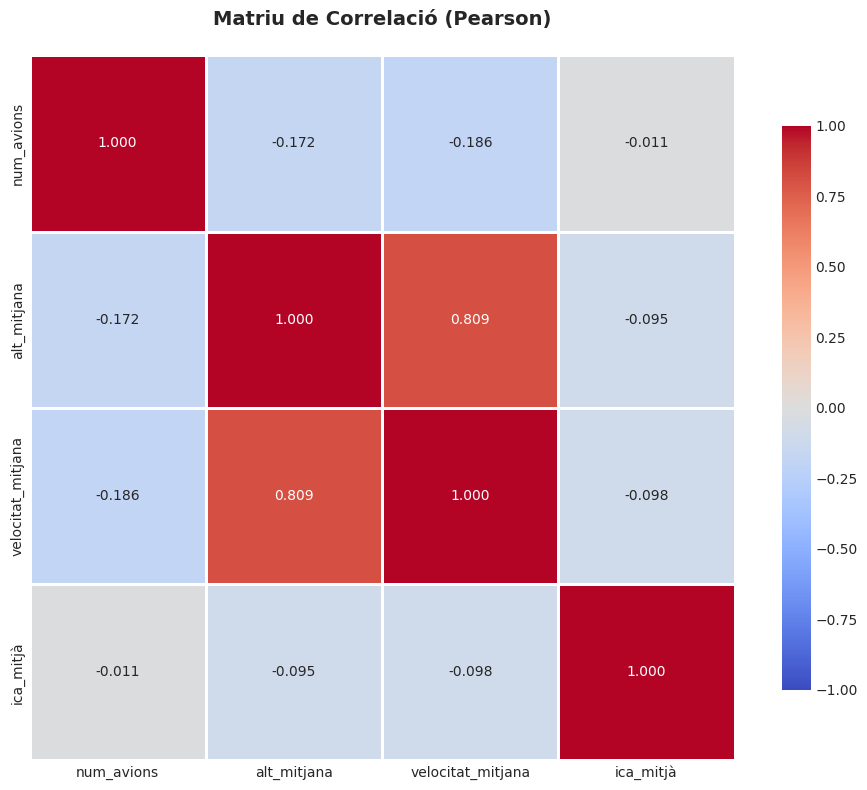

In [11]:
# Matriu de correlació entre totes les variables
variables_correlacio = ['num_avions', 'alt_mitjana', 'velocitat_mitjana', 'ica_mitjà']
corr_matrix = dades_analisi[variables_correlacio].corr()

# Visualització
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1)
plt.title('Matriu de Correlació (Pearson)\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2. Anàlisi per tipus d'estació

In [12]:
print("\nCORRELACIÓ PER TIPUS D'ESTACIÓ:\n")

for tipo in sorted(dades_analisi['tipo'].unique()):
    subset = dades_analisi[dades_analisi['tipo'] == tipo]
    if len(subset) >= 10:  # Mínim 10 observacions per calcular correlació
        r, p = pearsonr(subset['num_avions'], subset['ica_mitjà'])
        print(f"{tipo:30s} | r={r:6.3f} | p={p:.2e} | n={len(subset):4d} |")
    else:
        print(f"{tipo:30s} | Dades insuficients (n={len(subset)})")


CORRELACIÓ PER TIPUS D'ESTACIÓ:

FONDO                          | r=-0.037 | p=1.37e-01 | n=1579 |
INDUSTRIAL                     | r= 0.169 | p=3.37e-06 | n= 751 |
TRAFICO                        | r=-0.224 | p=6.77e-07 | n= 483 |


## 4. Visualitzacions de l'anàlisi de correlació

### 4.1. Scatter Plot: Relació Avions vs ICA

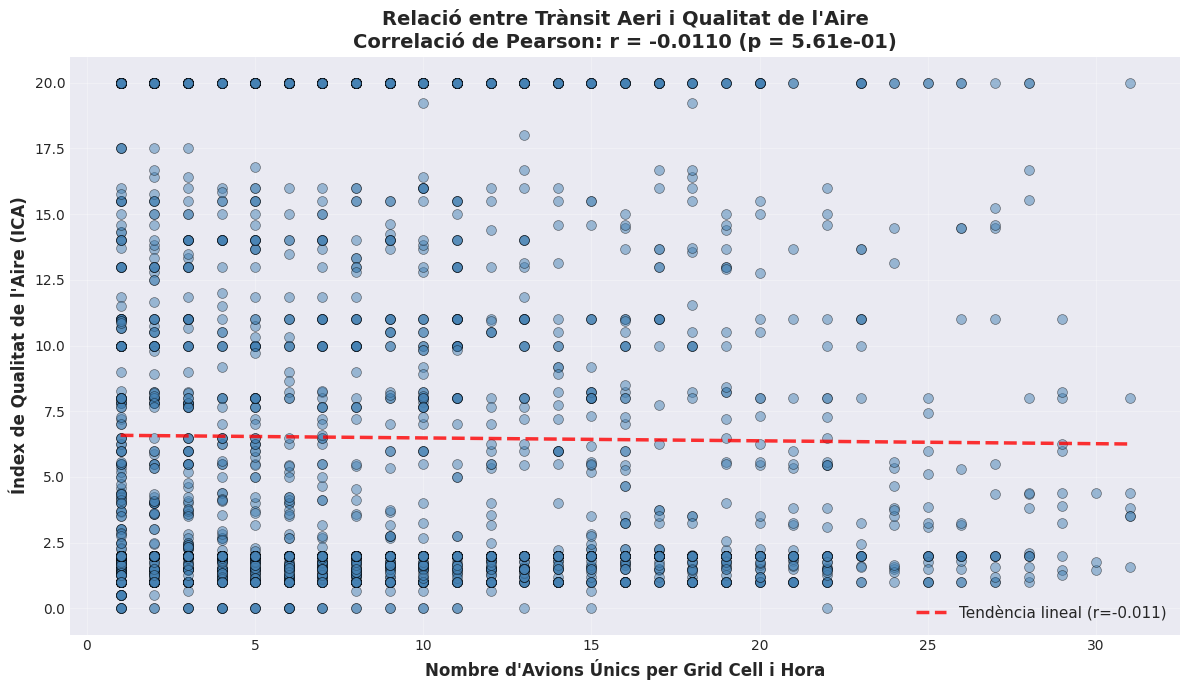

In [13]:
# Scatter plot detallat
plt.figure(figsize=(12, 7))
plt.scatter(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 
            alpha=0.5, s=50, color='steelblue', edgecolors='black', linewidth=0.5)

# Línia de tendència
z = np.polyfit(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 1)
p = np.poly1d(z)
x_trend = np.linspace(dades_analisi['num_avions'].min(), dades_analisi['num_avions'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2.5, 
         label=f'Tendència lineal (r={pearson_corr:.3f})')

plt.xlabel('Nombre d\'Avions Únics per Grid Cell i Hora', fontsize=12, fontweight='bold')
plt.ylabel('Índex de Qualitat de l\'Aire (ICA)', fontsize=12, fontweight='bold')
plt.title(f'Relació entre Trànsit Aeri i Qualitat de l\'Aire\n' +
          f'Correlació de Pearson: r = {pearson_corr:.4f} (p = {pearson_p:.2e})',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/scatter_airplane _ica.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2. Distribucions

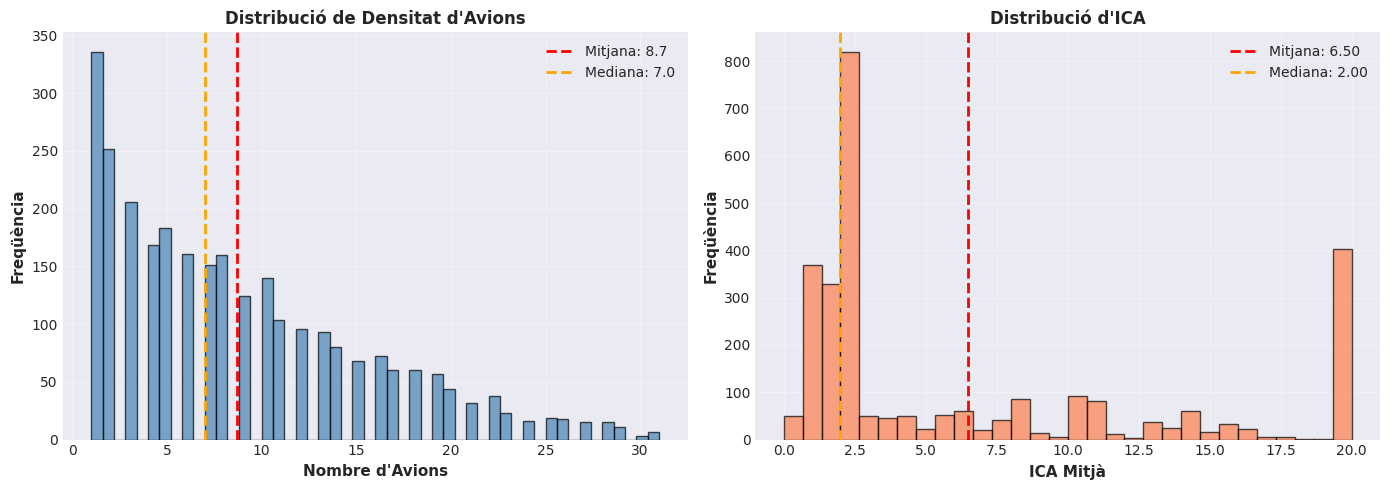

In [14]:
# Distribucions de les variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribució d'avions
axes[0].hist(dades_analisi['num_avions'], bins=50, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(dades_analisi['num_avions'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mitjana: {dades_analisi["num_avions"].mean():.1f}')
axes[0].axvline(dades_analisi['num_avions'].median(), color='orange', 
                linestyle='--', linewidth=2, label=f'Mediana: {dades_analisi["num_avions"].median():.1f}')
axes[0].set_xlabel('Nombre d\'Avions', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Freqüència', fontsize=11, fontweight='bold')
axes[0].set_title('Distribució de Densitat d\'Avions', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribució d'ICA
axes[1].hist(dades_analisi['ica_mitjà'], bins=30, color='coral', 
             edgecolor='black', alpha=0.7)
axes[1].axvline(dades_analisi['ica_mitjà'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mitjana: {dades_analisi["ica_mitjà"].mean():.2f}')
axes[1].axvline(dades_analisi['ica_mitjà'].median(), color='orange', 
                linestyle='--', linewidth=2, label=f'Mediana: {dades_analisi["ica_mitjà"].median():.2f}')
axes[1].set_xlabel('ICA Mitjà', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Freqüència', fontsize=11, fontweight='bold')
axes[1].set_title('Distribució d\'ICA', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3. Box Plots per Tipus d'Estació

<Figure size 1200x600 with 0 Axes>

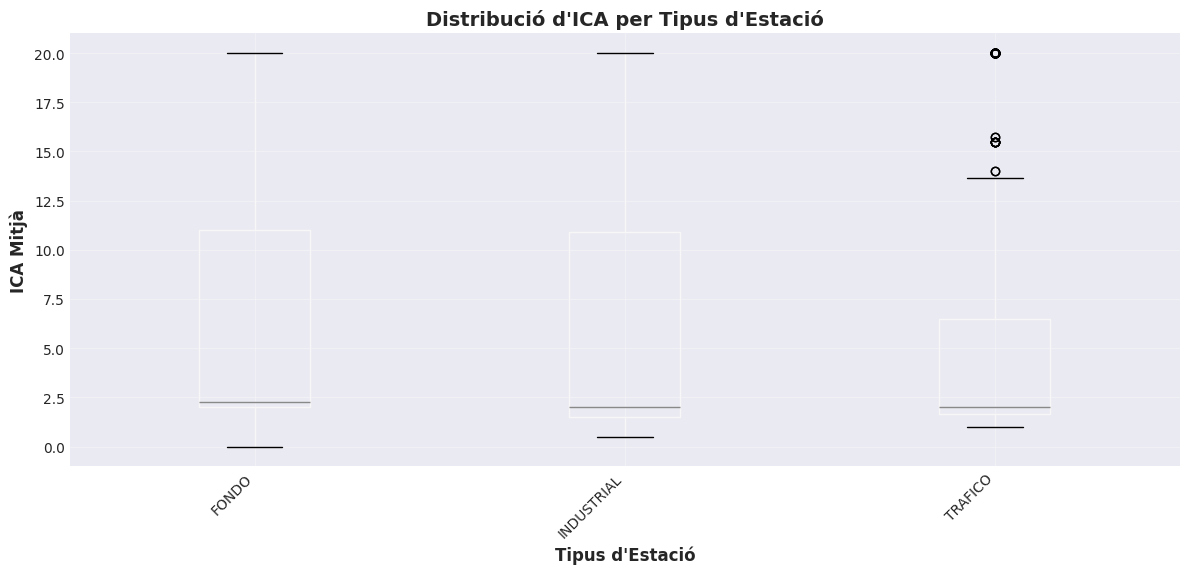

In [15]:
# Box plots per tipus d'estació
plt.figure(figsize=(12, 6))
dades_analisi.boxplot(column='ica_mitjà', by='tipo', figsize=(12, 6))
plt.xlabel('Tipus d\'Estació', fontsize=12, fontweight='bold')
plt.ylabel('ICA Mitjà', fontsize=12, fontweight='bold')
plt.title('Distribució d\'ICA per Tipus d\'Estació', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/boxplot_type.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.4. Hexbin Plot (Densitat 2D)

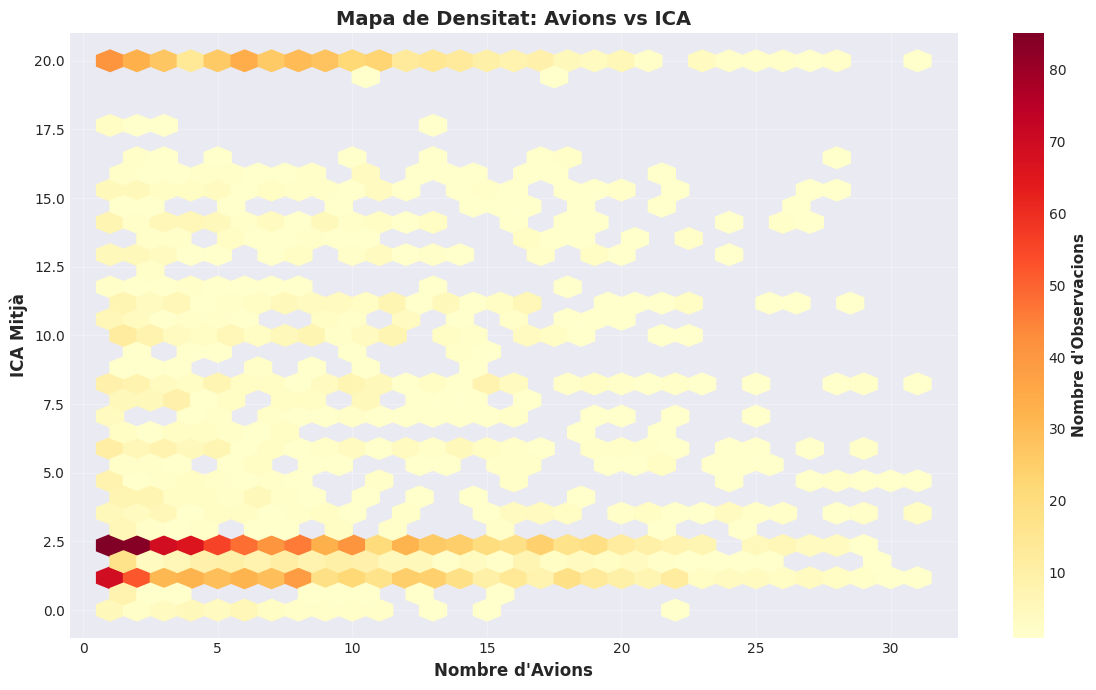

In [16]:
# Hexbin plot
plt.figure(figsize=(12, 7))
plt.hexbin(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 
           gridsize=30, cmap='YlOrRd', mincnt=1)
cb = plt.colorbar(label='Nombre d\'Observacions')
cb.set_label('Nombre d\'Observacions', fontsize=11, fontweight='bold')

plt.xlabel('Nombre d\'Avions', fontsize=12, fontweight='bold')
plt.ylabel('ICA Mitjà', fontsize=12, fontweight='bold')
plt.title('Mapa de Densitat: Avions vs ICA', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/hexbin_density.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5. Evolució Temporal

**Important:** Usem avions ÚNICS per hora (no sumem deteccions).

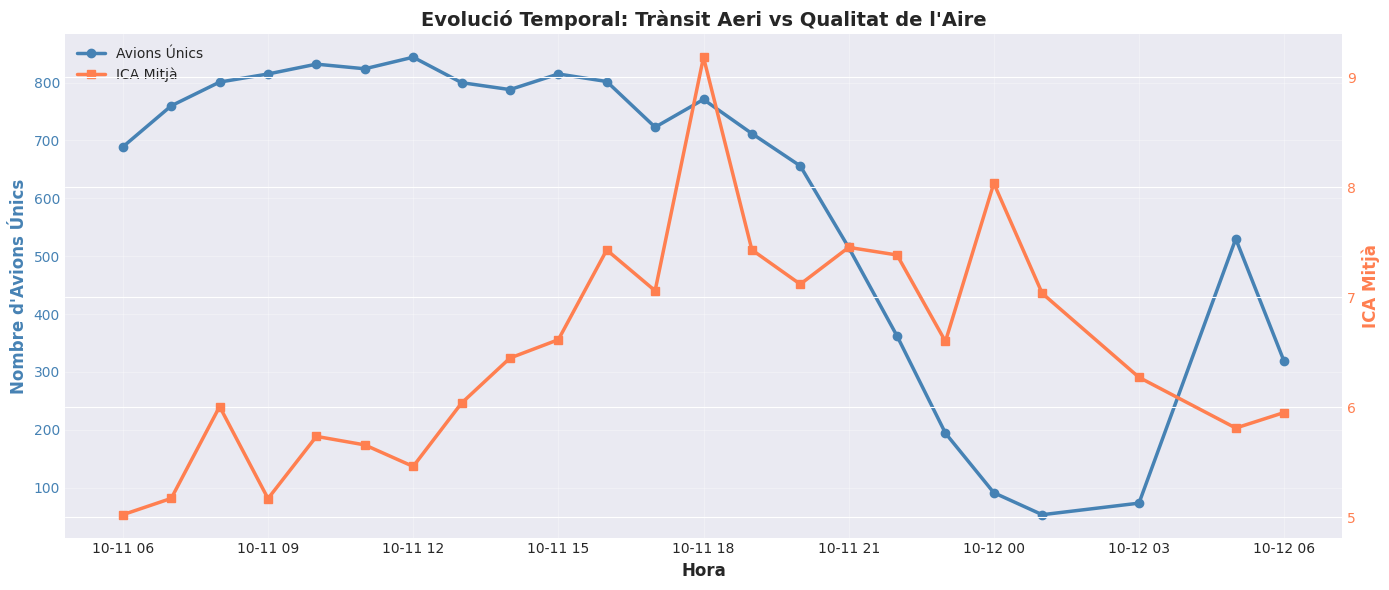


Estadístiques temporals:
- Avions únics mitjans per hora: 598.6
- Rang d'avions: 53 - 844
- ICA mitjà temporal: 6.52


In [17]:
# Comptar avions únics per hora
temporal_avions = df_adsb.groupby('hora')['hex'].nunique().reset_index()
temporal_avions.columns = ['hora', 'num_avions_unics']

# ICA mitjà per hora
temporal_ica = dades_analisi.groupby('hora')['ica_mitjà'].mean().reset_index()

# Combinar
temporal = pd.merge(temporal_avions, temporal_ica, on='hora')

# Visualització
fig, ax1 = plt.subplots(figsize=(14, 6))

# Avions (eix esquerre)
ax1.plot(temporal['hora'], temporal['num_avions_unics'], 
         color='steelblue', linewidth=2.5, label='Avions Únics', marker='o', markersize=6)
ax1.set_xlabel('Hora', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre d\'Avions Únics', color='steelblue', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3)

# ICA (eix dret)
ax2 = ax1.twinx()
ax2.plot(temporal['hora'], temporal['ica_mitjà'], 
         color='coral', linewidth=2.5, label='ICA Mitjà', marker='s', markersize=6)
ax2.set_ylabel('ICA Mitjà', color='coral', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='coral')

plt.title('Evolució Temporal: Trànsit Aeri vs Qualitat de l\'Aire', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Combinar llegendes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('../outputs/figures/temporal_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEstadístiques temporals:")
print(f"- Avions únics mitjans per hora: {temporal['num_avions_unics'].mean():.1f}")
print(f"- Rang d'avions: {temporal['num_avions_unics'].min():.0f} - {temporal['num_avions_unics'].max():.0f}")
print(f"- ICA mitjà temporal: {temporal['ica_mitjà'].mean():.2f}")

### 4.6. Figura Resum

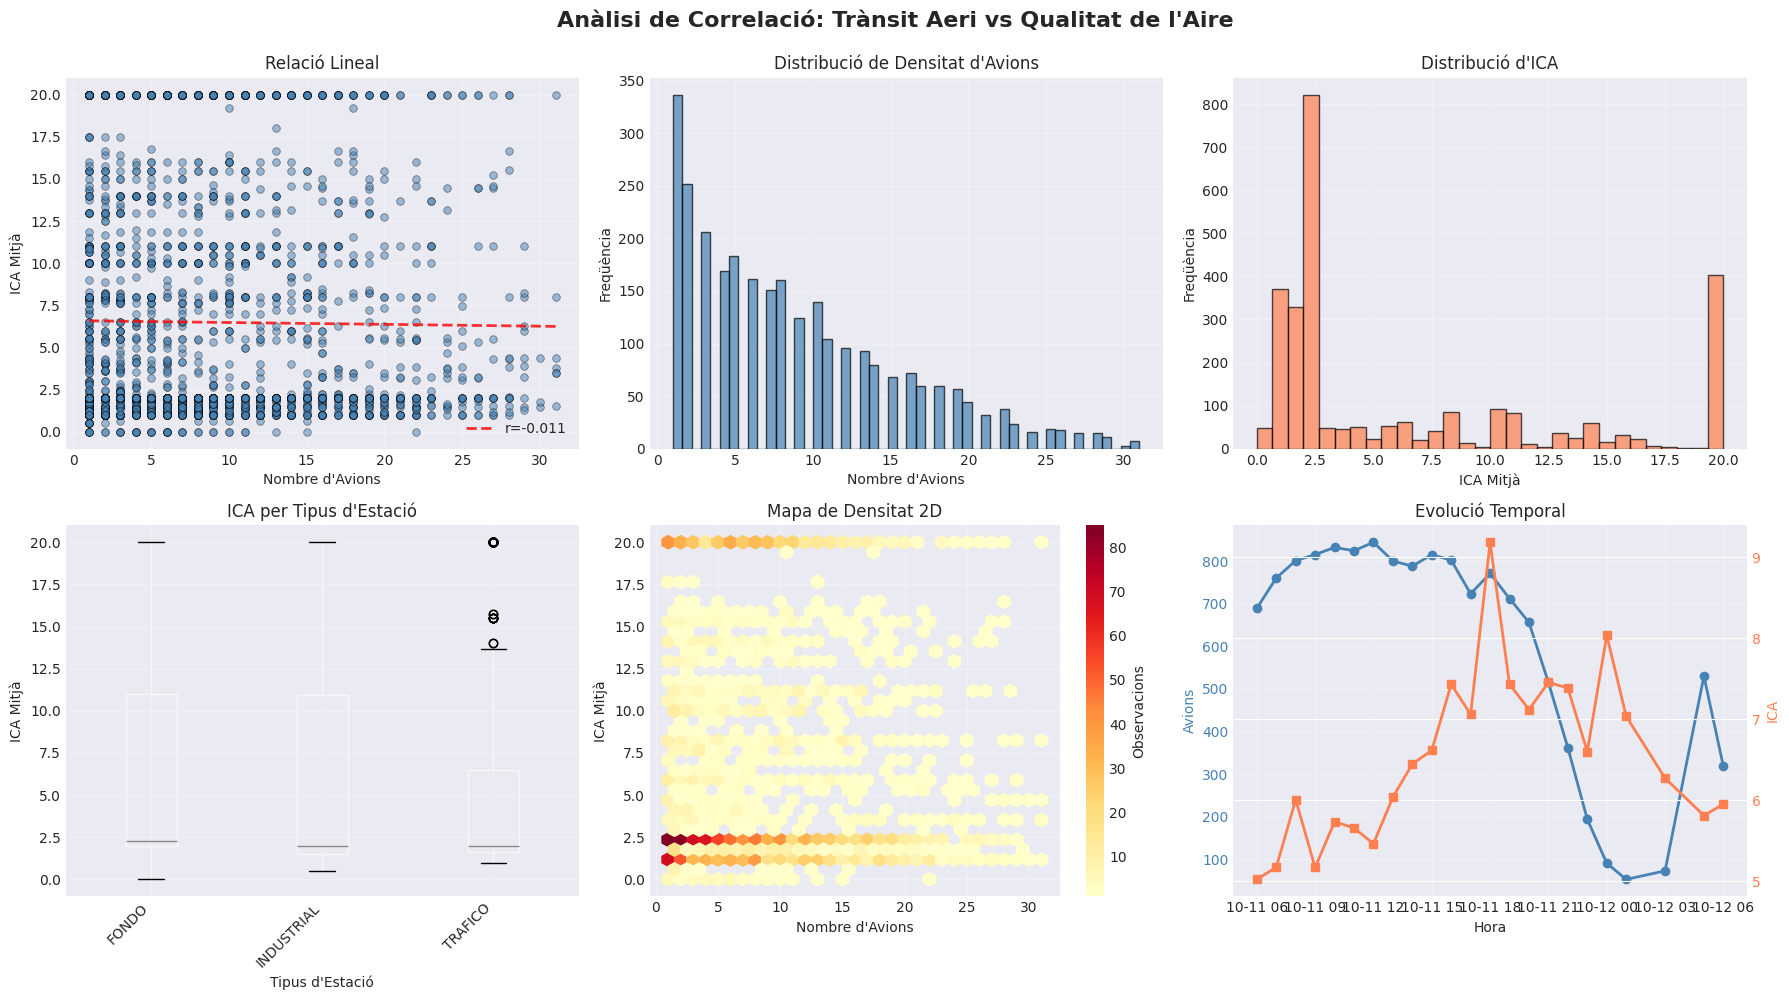

In [18]:
# Figura resum amb tots els gràfics
fig = plt.figure(figsize=(18, 10))

# 1. Scatter plot
ax1 = plt.subplot(2, 3, 1)
plt.scatter(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 
            alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 1)
p = np.poly1d(z)
plt.plot(dades_analisi['num_avions'].sort_values(), 
         p(dades_analisi['num_avions'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, label=f'r={pearson_corr:.3f}')
plt.xlabel('Nombre d\'Avions')
plt.ylabel('ICA Mitjà')
plt.title('Relació Lineal')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Distribució avions
ax2 = plt.subplot(2, 3, 2)
plt.hist(dades_analisi['num_avions'], bins=50, color='steelblue', 
         edgecolor='black', alpha=0.7)
plt.xlabel('Nombre d\'Avions')
plt.ylabel('Freqüència')
plt.title('Distribució de Densitat d\'Avions')
plt.grid(True, alpha=0.3)

# 3. Distribució ICA
ax3 = plt.subplot(2, 3, 3)
plt.hist(dades_analisi['ica_mitjà'], bins=30, color='coral', 
         edgecolor='black', alpha=0.7)
plt.xlabel('ICA Mitjà')
plt.ylabel('Freqüència')
plt.title('Distribució d\'ICA')
plt.grid(True, alpha=0.3)

# 4. Box plots
ax4 = plt.subplot(2, 3, 4)
dades_analisi.boxplot(column='ica_mitjà', by='tipo', ax=ax4)
plt.xlabel('Tipus d\'Estació')
plt.ylabel('ICA Mitjà')
plt.title('ICA per Tipus d\'Estació')
plt.suptitle('')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 5. Hexbin
ax5 = plt.subplot(2, 3, 5)
plt.hexbin(dades_analisi['num_avions'], dades_analisi['ica_mitjà'], 
           gridsize=30, cmap='YlOrRd', mincnt=1)
plt.colorbar(label='Observacions')
plt.xlabel('Nombre d\'Avions')
plt.ylabel('ICA Mitjà')
plt.title('Mapa de Densitat 2D')
plt.grid(True, alpha=0.3)

# 6. Evolució temporal
ax6 = plt.subplot(2, 3, 6)
ax6_twin = ax6.twinx()
ax6.plot(temporal['hora'], temporal['num_avions_unics'], 
         color='steelblue', linewidth=2, label='Avions', marker='o')
ax6_twin.plot(temporal['hora'], temporal['ica_mitjà'], 
              color='coral', linewidth=2, label='ICA', marker='s')
ax6.set_xlabel('Hora')
ax6.set_ylabel('Avions', color='steelblue')
ax6_twin.set_ylabel('ICA', color='coral')
ax6.tick_params(axis='y', labelcolor='steelblue')
ax6_twin.tick_params(axis='y', labelcolor='coral')
plt.title('Evolució Temporal')
ax6.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Títol general
fig.suptitle('Anàlisi de Correlació: Trànsit Aeri vs Qualitat de l\'Aire', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('../outputs/figures/correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Anàlisi de Regressió Lineal

Per quantificar quant de la variabilitat de la qualitat de l'aire pot ser explicada pel trànsit aeri, s'ajusta un model de Regressió Lineal (`LinearRegression` de Scikit-Learn).

$$ICA = \beta_0 + \beta_1 \cdot (NumVols) + \epsilon$$

S'avaluen les mètriques de rendiment del model:
- **$R^2$ (Coeficient de determinació):** Indica el percentatge de variància de l'ICA explicat pel trànsit aeri.
- **MAE (Error Absolut Mitjà):** La magnitud mitjana dels errors en les mateixes unitats que l'ICA.
- **RMSE (Arrel de l'Error Quadràtic Mitjà):** Penalitza més els errors grans.

### 5.1 Preparació i entrenament del model

In [19]:
# Preparar dades
X = dades_analisi[['num_avions']].values
y = dades_analisi['ica_mitjà'].values

# Crear i entrenar model
model = LinearRegression()
model.fit(X, y)

# Prediccions
y_pred = model.predict(X)

# Mètriques
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"\nMètriques del model:")
print(f"- R² Score: {r2:.4f}")
print(f"- MAE (Error Absolut Mitjà): {mae:.4f}")
print(f"- RMSE (Error Quadràtic Mitjà): {rmse:.4f}")


Mètriques del model:
- R² Score: 0.0001
- MAE (Error Absolut Mitjà): 5.7891
- RMSE (Error Quadràtic Mitjà): 6.7945


### 5.2 Visualització del model

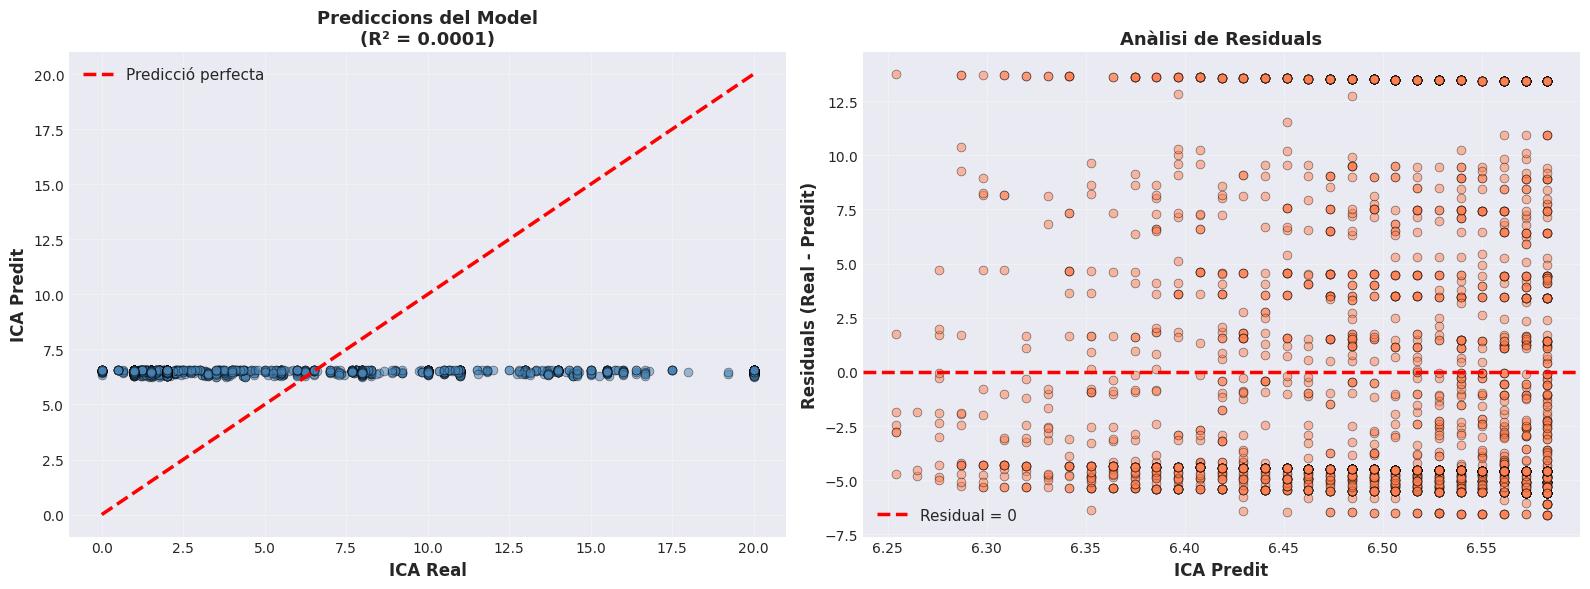

In [20]:
# Visualització del model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Prediccions vs Real
axes[0].scatter(y, y_pred, alpha=0.5, s=40, color='steelblue', 
                edgecolors='black', linewidth=0.5)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 
             'r--', lw=2.5, label='Predicció perfecta')
axes[0].set_xlabel('ICA Real', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ICA Predit', fontsize=12, fontweight='bold')
axes[0].set_title(f'Prediccions del Model\n(R² = {r2:.4f})', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. Anàlisi de residuals
residuals = y - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=40, color='coral', 
                edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2.5, label='Residual = 0')
axes[1].set_xlabel('ICA Predit', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Real - Predit)', fontsize=12, fontweight='bold')
axes[1].set_title('Anàlisi de Residuals', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/regression_model.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Test de normalitat

In [21]:
# Test de normalitat dels residuals
stat, p_shapiro = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
print(f"\nTest de Shapiro-Wilk (normalitat dels residuals):")
print(f"- Estadístic: {stat:.4f}")
print(f"- P-valor: {p_shapiro:.4e}")


Test de Shapiro-Wilk (normalitat dels residuals):
- Estadístic: 0.7525
- P-valor: 5.4214e-54


## 6. Conclusions i Resum Final

In [22]:
print("RESUM DE L'ANÀLISI:")

print(f"\nDADES ANALITZADES:")
print(f"- Observacions combinades: {len(dades_analisi):,}")
print(f"- Grid cells úniques: {dades_analisi['cell_id'].nunique()}")
print(f"- Període: {dades_analisi['hora'].min()} - {dades_analisi['hora'].max()}")
print(f"- Avions únics detectats: {df_adsb['hex'].nunique():,}")
print(f"- Estacions ICA: {df_ica['cod_estacion'].nunique()}")

print(f"\nCORRELACIÓ:")
print(f"- Pearson: r = {pearson_corr:.4f}, p = {pearson_p:.2e}")
print(f"- Spearman: ρ = {spearman_corr:.4f}, p = {spearman_p:.2e}")

print(f"\nMODEL PREDICTIU:")
print(f"- R² Score: {r2:.4f}")
print(f"- Poder explicatiu: {r2*100:.2f}%")
print(f"- MAE: {mae:.4f}")
print(f"- RMSE: {rmse:.4f}")

RESUM DE L'ANÀLISI:

DADES ANALITZADES:
- Observacions combinades: 2,813
- Grid cells úniques: 143
- Període: 2025-10-11 06:00:00 - 2025-10-12 06:00:00
- Avions únics detectats: 2,943
- Estacions ICA: 505

CORRELACIÓ:
- Pearson: r = -0.0110, p = 5.61e-01
- Spearman: ρ = 0.0066, p = 7.27e-01

MODEL PREDICTIU:
- R² Score: 0.0001
- Poder explicatiu: 0.01%
- MAE: 5.7891
- RMSE: 6.7945
